In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import h5py
import math
from datetime import datetime

# Furcifar Modules
from preprocessing.util import find_files
from preprocessing.datamodel import SlideManager
from preprocessing.util import TileMap
#from read_tiles_with_mask import TissueDataset

%matplotlib inline

In [2]:
GENERATED_DATA = '/home/sarah/ForthBrainCancer-Dataset/training_CAMELYON16/'
SINGLE_FILE = GENERATED_DATA + 'all_wsis_312x312_poi0.4_level3.hdf5'

In [3]:
MODEL_CHECKPOINT = GENERATED_DATA + 'model_checkpoint.ckpt'
MODEL_FINAL = GENERATED_DATA + 'model_final.hdf5'

In [4]:
# Create one giant hdf5
import os
#SINGLE_FILE = '{}/all_wsis_312x312_poi0.4_level3.hdf5'.format(GENERATED_DATA)
#h5_single = h5py.File(SINGLE_FILE, 'w')
#for f in os.listdir(GENERATED_DATA):
#    if f.startswith('normal_') or f.startswith('tumor_'):
#        filename = GENERATED_DATA + f
#        with h5py.File(filename, 'r') as h5:
#            for key in h5.keys():
#                print('processing: "{}", shape: {}'.format(key, h5[key].shape))
#                if h5[key].shape[0] > 0: ### dont create dsets for WSIs with 0 tiles
#                    dset = h5_single.create_dataset(key, 
#                        h5[key].shape, 
#                        dtype=np.uint8,
#                        data=h5[key][:],
#                        compression=0) 
            
#h5_single.close()

In [19]:
file = '/home/sarah/ForthBrainCancer-Dataset/testing_CAMELYON16/tumor_117_256x256_poi0.2_level3.hdf5'
data_file = h5py.File(file, 'r', libver='latest', swmr=True)
for key in data_file.keys():
    print(key, 'with shape', data_file[key].shape)

tumor_117 with shape (0, 256, 256, 3)


In [5]:
data_file = h5py.File(SINGLE_FILE, 'r', libver='latest', swmr=True)
print('List of data entries')
for key in data_file.keys():
    print(key, 'with shape', data_file[key].shape)

List of data entries
normal_001 with shape (126, 312, 312, 3)
normal_002 with shape (225, 312, 312, 3)
normal_003 with shape (268, 312, 312, 3)
normal_004 with shape (80, 312, 312, 3)
normal_005 with shape (179, 312, 312, 3)
normal_006 with shape (59, 312, 312, 3)
normal_007 with shape (215, 312, 312, 3)
normal_008 with shape (118, 312, 312, 3)
normal_009 with shape (323, 312, 312, 3)
normal_010 with shape (140, 312, 312, 3)
normal_011 with shape (599, 312, 312, 3)
normal_012 with shape (161, 312, 312, 3)
normal_013 with shape (102, 312, 312, 3)
normal_014 with shape (159, 312, 312, 3)
normal_015 with shape (295, 312, 312, 3)
normal_016 with shape (57, 312, 312, 3)
normal_017 with shape (26, 312, 312, 3)
normal_018 with shape (161, 312, 312, 3)
normal_019 with shape (16, 312, 312, 3)
normal_020 with shape (48, 312, 312, 3)
normal_021 with shape (23, 312, 312, 3)
normal_022 with shape (329, 312, 312, 3)
normal_023 with shape (89, 312, 312, 3)
normal_024 with shape (688, 312, 312, 3)
nor

In [6]:
class TissueDataset():
    """Data set for preprocessed WSIs of the CAMELYON16 and CAMELYON17 data set."""
        
    def __init__(self, path, percentage=.5, first_part=True):      
        self.h5_file = path
        self.h5 = h5py.File(path, 'r', libver='latest', swmr=True)
        self.perc = percentage
        self.first_part = first_part
        self.dataset_names = list(self.h5.keys())
        self.neg = [i for i in self.dataset_names if 'ormal' in i]
        self.pos = [i for i in self.dataset_names if 'umor' in i]
        self.dims = self.h5[self.neg[0]][0].shape
    
    def __get_tiles_from_path(self, dataset_names, max_wsis, number_tiles):
        tiles = np.ndarray((number_tiles, 256, 256, 3))
        for i in range(number_tiles):
            file_idx = np.random.randint(0, max_wsis)
            dset = self.h5[dataset_names[file_idx]]
            len_ds = len(dset)
            max_tiles = math.ceil(len_ds * self.perc)
            if self.first_part:
                rnd_idx = np.random.randint(0, max_tiles)
            else:
                rnd_idx = np.random.randint(len_ds - max_tiles, len_ds)
            ### crop random 256x256
            if self.dims[1] > 256:
                rand_height = np.random.randint(0, self.dims[0]-256)
                rand_width = np.random.randint(0, self.dims[1]-256)
            else:
                rand_height = 0
                rand_width = 0
            tiles[i] = dset[rnd_idx,rand_height:rand_height+256,rand_width:rand_width+256]
        tiles = tiles / 255.
        return tiles
    
    def __get_random_positive_tiles(self, number_tiles):
        return self.__get_tiles_from_path(self.pos, len(self.pos), number_tiles), np.ones((number_tiles))
    
    def __get_random_negative_tiles(self, number_tiles):
        return self.__get_tiles_from_path(self.neg, len(self.neg), number_tiles), np.zeros((number_tiles))
    
    def generator(self, num_neg=10, num_pos=10, data_augm=False, mean=[0.,0.,0.], std=[1.,1.,1.]):
        while True:
            x, y = self.get_batch(num_neg, num_pos, data_augm)
            for i in [0,1,2]:
                x[:,:,:,i] = (x[:,:,:,i] - mean[i]) / std[i]
            yield x, y

    def get_batch(self, num_neg=10, num_pos=10, data_augm=False):
        x_p, y_p = self.__get_random_positive_tiles(num_pos)
        x_n, y_n = self.__get_random_negative_tiles(num_neg)
        x = np.concatenate((x_p, x_n), axis=0)
        y = np.concatenate((y_p, y_n), axis=0)
        if data_augm:
            ### some data augmentation mirroring / rotation
            if np.random.randint(0,2): x = np.flip(x, axis=1)
            if np.random.randint(0,2): x = np.flip(x, axis=2)
            x = np.rot90(m=x, k=np.random.randint(0,4), axes=(1,2))
        ### randomly arrange in order
        p = np.random.permutation(len(y))
        return x[p], y[p]

In [7]:
train_data = TissueDataset(path=SINGLE_FILE, percentage=0.5, first_part=True)
val_data = TissueDataset(path=SINGLE_FILE, percentage=0.5, first_part=False)

x, y = train_data.get_batch(num_neg=3, num_pos=3)
print(x.shape)
print(y)

(6, 256, 256, 3)
[0. 0. 1. 1. 0. 1.]


(2, 256, 256, 3)


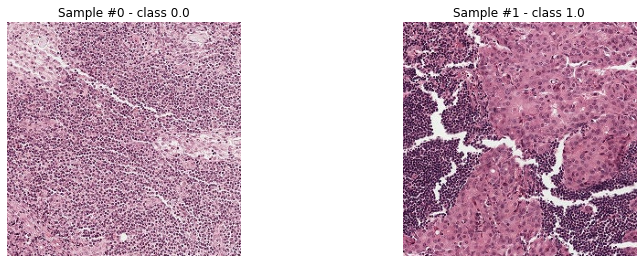

In [8]:
 plt.figure(figsize=(12,4))

itera = train_data.generator(num_neg=1, num_pos=1, data_augm=True)
for x, y in itera:
    print(x.shape)
    for i in range(2):
        ax = plt.subplot(1, 2, i + 1)
        plt.tight_layout()
        ax.set_title('Sample #{} - class {}'.format(i, y[i]))
        ax.imshow(x[i])
        ax.axis('off') 
    break # generate yields infinite random samples, so we stop after first

In [9]:
base_model = keras.applications.InceptionResNetV2(
                                 include_top=False, 
                                 weights='imagenet', 
                                 input_shape=(256,256,3), 
                                 )

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
predictions = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

batch_size_neg=20
batch_size_pos=20
batches_per_train_epoch = 100
batches_per_val_epoch = 50
epochs = 50

In [11]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(MODEL_CHECKPOINT, 
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

In [12]:
now1 = datetime.now()

### Uncomment to easily disable color normalization
mean_pixel = [0.,0.,0.] 
std_pixel = [1.,1.,1.]  

for i in range(epochs):
    hist = model.fit_generator(
            generator=train_data.generator(batch_size_neg, batch_size_pos, True, mean_pixel, std_pixel),
            steps_per_epoch=batches_per_train_epoch, 
            validation_data=val_data.generator(batch_size_neg, batch_size_pos, False, mean_pixel, std_pixel),
            validation_steps=batches_per_val_epoch,
            callbacks=[cp_callback], workers=1, use_multiprocessing=False, max_queue_size=10)
    
    train_accs.append(hist.history['accuracy'])
    train_losses.append(hist.history['loss'])
    val_accs.append(hist.history['val_accuracy'])
    val_losses.append(hist.history['val_loss'])

now2 = datetime.now()
print(now2 - now1)

/usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 [==============================] - 5207s 52s/step - loss: 0.2878 - accuracy: 0.8626 - val_loss: 0.5770 - val_accuracy: 0.8550

Epoch 00001: val_loss improved from inf to 0.57698, saving model to /home/sarah/ForthBrainCancer-Dataset/training_CAMELYON16/model_checkpoint.ckpt
100/100 [==============================] - 5154s 52s/step - loss: 0.0474 - accuracy: 0.9865 - val_loss: 0.2795 - val_accuracy: 0.9250

Epoch 00001: val_loss improved from 0.57698 to 0.27948, saving model to /home/sarah/ForthBrainCancer-Dataset/training_CAMELYON16/model_checkpoint.ckpt
100/100 [==============================] - 5150s 52s/step - loss: 0.0256 - accuracy: 0.9912 - val_loss: 0.0818 - val_accuracy: 0.9770

Epoch 00001: val_loss improved from 0.27948 to 0.08179, saving model to /home/sarah/ForthBrainCancer-Dataset/training_CAMELYON16/model_checkpoint.ckpt
100/100 [==============================] - 5132s 51s/step - loss: 0.0252 - accuracy: 0.9930 - val_loss: 0.0640 - val_accuracy: 0.9805

Epoch 00001

In [13]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
# If I stop early, load good model

In [14]:
# Save entire model to a HDF5 file
model.save(MODEL_FINAL)

In [20]:
# Do test things and make graphs
HDF5_FOLDER = '/home/sarah/ForthBrainCancer-Dataset/testing_CAMELYON16'

In [24]:
GENERATED_DATA = '/home/sarah/ForthBrainCancer-Dataset/testing_CAMELYON16/'
TEST_FILE = GENERATED_DATA + 'all_wsis_312x312_poi0.4_level3.hdf5'
#SINGLE_FILE = '{}/all_wsis_312x312_poi0.4_level3.hdf5'.format(GENERATED_DATA)
h5_single = h5py.File(TEST_FILE, 'w')
for f in os.listdir(GENERATED_DATA):
    if f.startswith('normal_') or f.startswith('tumor_'):
        filename = GENERATED_DATA + f
        with h5py.File(filename, 'r') as h5:
            for key in h5.keys():
                print('processing: "{}", shape: {}'.format(key, h5[key].shape))
                if h5[key].shape[0] > 0: ### dont create dsets for WSIs with 0 tiles
                    dset = h5_single.create_dataset(key, 
                        h5[key].shape, 
                        dtype=np.uint8,
                        data=h5[key][:],
                        compression=0) 
            
h5_single.close()

processing: "normal_031", shape: (954, 256, 256, 3)
processing: "normal_045", shape: (327, 256, 256, 3)
processing: "tumor_074", shape: (5, 256, 256, 3)
processing: "normal_118", shape: (322, 256, 256, 3)
processing: "normal_005", shape: (321, 256, 256, 3)
processing: "tumor_040", shape: (479, 256, 256, 3)
processing: "normal_025", shape: (178, 256, 256, 3)
processing: "normal_091", shape: (379, 256, 256, 3)
processing: "normal_124", shape: (156, 256, 256, 3)
processing: "tumor_068", shape: (191, 256, 256, 3)
processing: "normal_059", shape: (554, 256, 256, 3)
processing: "tumor_048", shape: (2, 256, 256, 3)
processing: "tumor_094", shape: (118, 256, 256, 3)
processing: "normal_019", shape: (1001, 256, 256, 3)
processing: "tumor_121", shape: (36, 256, 256, 3)
processing: "normal_085", shape: (360, 256, 256, 3)
processing: "normal_039", shape: (193, 256, 256, 3)
processing: "tumor_008", shape: (4, 256, 256, 3)
processing: "normal_130", shape: (477, 256, 256, 3)
processing: "normal_125",

In [25]:
data_file = h5py.File(TEST_FILE, 'r', libver='latest', swmr=True)
print('List of data entries')
for key in data_file.keys():
    print(key, 'with shape', data_file[key].shape)

List of data entries
normal_003 with shape (602, 256, 256, 3)
normal_005 with shape (321, 256, 256, 3)
normal_006 with shape (803, 256, 256, 3)
normal_007 with shape (447, 256, 256, 3)
normal_009 with shape (548, 256, 256, 3)
normal_012 with shape (1001, 256, 256, 3)
normal_014 with shape (1001, 256, 256, 3)
normal_015 with shape (209, 256, 256, 3)
normal_017 with shape (400, 256, 256, 3)
normal_018 with shape (592, 256, 256, 3)
normal_019 with shape (1001, 256, 256, 3)
normal_020 with shape (113, 256, 256, 3)
normal_022 with shape (1001, 256, 256, 3)
normal_023 with shape (555, 256, 256, 3)
normal_024 with shape (330, 256, 256, 3)
normal_025 with shape (178, 256, 256, 3)
normal_028 with shape (989, 256, 256, 3)
normal_031 with shape (954, 256, 256, 3)
normal_032 with shape (876, 256, 256, 3)
normal_034 with shape (779, 256, 256, 3)
normal_035 with shape (615, 256, 256, 3)
normal_036 with shape (576, 256, 256, 3)
normal_037 with shape (1001, 256, 256, 3)
normal_039 with shape (193, 256

In [27]:
test_data = TissueDataset(TEST_FILE, percentage=0.1, first_part=False)

In [79]:
iter_norm = test_data.generator(num_neg=2000, num_pos=2000, data_augm=False)

In [80]:
i = 0
#Y, Y_pred = list(), list()
for x, y in iter_norm:
    y_pred = model.predict(x)
    i +=1
    if i == 1:
        break

In [81]:
y_pred

array([[9.9999559e-01],
       [9.9992168e-01],
       [1.0000000e+00],
       ...,
       [9.9988532e-01],
       [1.7217906e-05],
       [1.0000000e+00]], dtype=float32)

In [30]:
y_pred = np.around(y_pred.flatten())

In [78]:
y_pred

array([0., 0., 1., ..., 1., 1., 1.], dtype=float32)

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
print('Confusion Matrix')
print(confusion_matrix(y, y_pred))
print('Classification Report')
#target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(y, y_pred))

Confusion Matrix
[[1507  493]
 [ 110 1890]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.93      0.75      0.83      2000
         1.0       0.79      0.94      0.86      2000

    accuracy                           0.85      4000
   macro avg       0.86      0.85      0.85      4000
weighted avg       0.86      0.85      0.85      4000



In [33]:
from sklearn.metrics import accuracy_score
print('Accuracy score:')
print(accuracy_score(y, y_pred))

Accuracy score:
0.84925


### GradCam

In [34]:
import tf_keras_vis

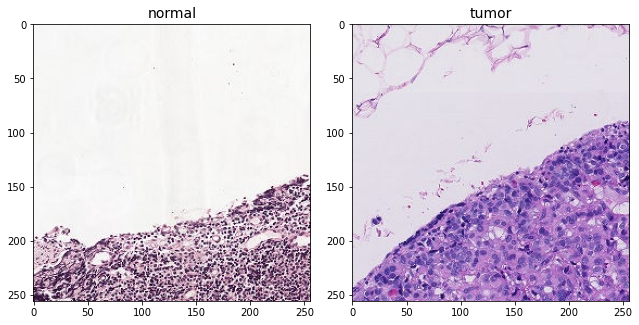

In [38]:
TEST_DATA = '/home/sarah/ForthBrainCancer-Dataset/testing_CAMELYON16/'
img1 = h5py.File(TEST_DATA + 'normal_003_256x256_poi0.2_level3.hdf5', 'r', libver='latest', swmr=True)
img1 = img1['normal_003'][0]
img2 = h5py.File(TEST_DATA + 'tumor_001_256x256_poi0.2_level3.hdf5', 'r', libver='latest', swmr=True)
img2 = img2['tumor_001'][0]
pics = [img1, img2]
titles = ['normal', 'tumor']
subplot_args = {'nrows': 1,
               'ncols': 2,
               'figsize': (9,9)}
f, ax = plt.subplots(**subplot_args)
for i in range(2):
    ax[i].set_title(titles[i], fontsize=14)
    ax[i].imshow(pics[i])
plt.tight_layout()
plt.show()

tf.Tensor(
[[-53920.57]
 [-56570.26]], shape=(2, 1), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


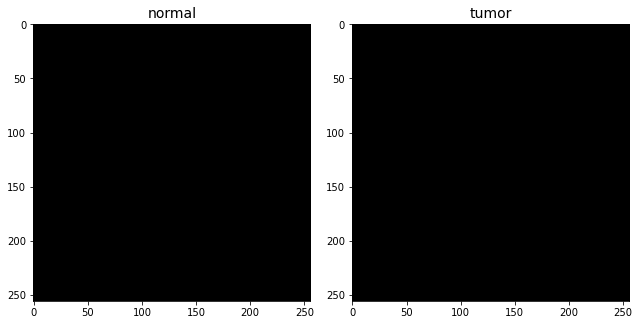

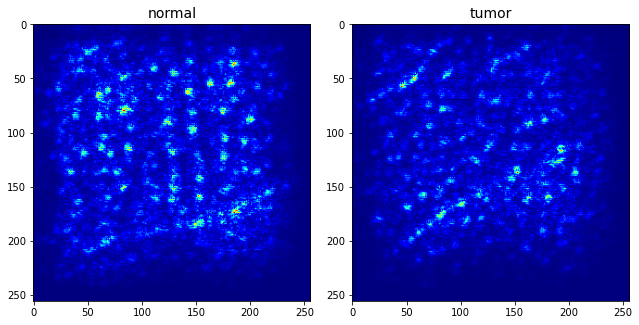

In [57]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tensorflow.keras.applications.vgg16 import preprocess_input

def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

# Output of model
def loss(output):
    print(output)
    return (output[0], output[1])

pics[0] = tf.cast(pics[0], tf.float32)
pics[1] = tf.cast(pics[1], tf.float32)

pics = np.asarray(pics)
X = preprocess_input(pics)

# Vanilla Saliency
saliency = Saliency(model,
                   model_modifier=model_modifier,
                   clone=False)

saliency_map = saliency(loss, X)
saliency_map = normalize(saliency_map)

f, ax = plt.subplots(**subplot_args)
for i in range(2):
    ax[i].set_title(titles[i], fontsize=14)
    ax[i].imshow(pics[i])
plt.tight_layout()
plt.show()

f, ax = plt.subplots(**subplot_args)
for i in range(2):
    ax[i].set_title(titles[i], fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
plt.tight_layout()
plt.show()

tf.Tensor(
[[-55719.83 ]
 [-58113.125]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[-55744.33]
 [-58060.82]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[-55779.64]
 [-58007.81]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[-55832.79]
 [-57967.22]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[-55801.03 ]
 [-57981.242]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[-55778.656]
 [-57988.96 ]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[-55805.562]
 [-58102.9  ]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[-55773.254]
 [-58032.49 ]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[-55718.992]
 [-58004.89 ]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[-55748.305]
 [-58021.07 ]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[-55649.516]
 [-58045.617]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[-55813.164]
 [-58017.438]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[-55727.934]
 [-58085.195]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[-55736.297]
 [-58157.71 ]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[-55757.293]
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


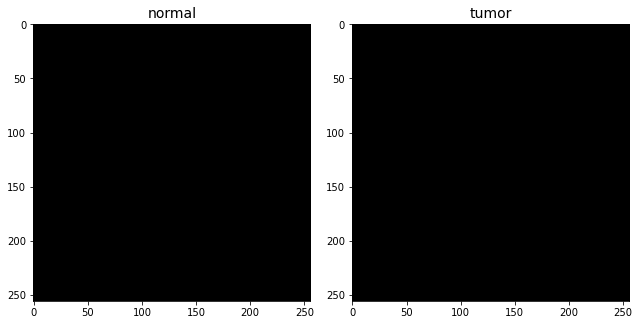

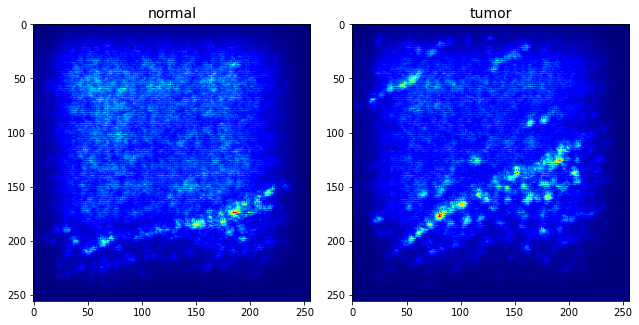

In [58]:
# Smooth Grad

saliency_map = saliency(loss,
                       X,
                       smooth_samples=20,
                       smooth_noise=0.20)
saliency_map = normalize(saliency_map)

f, ax = plt.subplots(**subplot_args)
for i in range(2):
    ax[i].set_title(titles[i], fontsize=14)
    ax[i].imshow(pics[i])
plt.tight_layout()
plt.show()

f, ax = plt.subplots(**subplot_args)
for i in range(2):
    ax[i].set_title(titles[i], fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
plt.tight_layout()
plt.show()

tf.Tensor(
[[-53920.57]
 [-56570.26]], shape=(2, 1), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


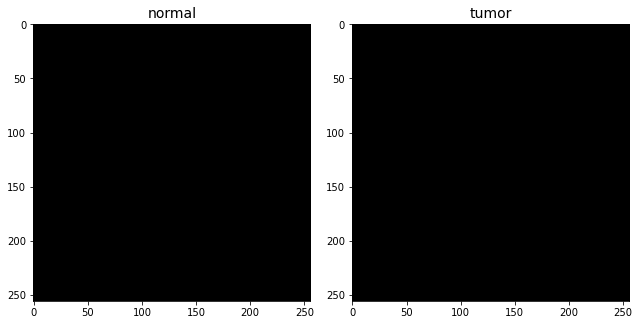

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


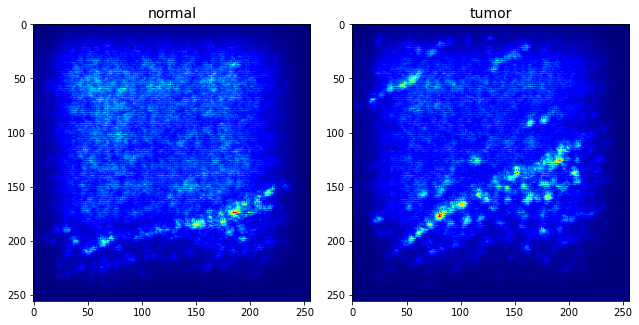

In [60]:
# Grad Cam

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(model,
                 model_modifier=model_modifier,
                 clone=False)
cam = gradcam(loss,
             X,
             penultimate_layer=-1)
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i in range(2):
    ax[i].set_title(titles[i], fontsize=14)
    ax[i].imshow(pics[i])
plt.tight_layout()
plt.show()

f, ax = plt.subplots(**subplot_args)
for i in range(2):
    ax[i].set_title(titles[i], fontsize=14)
    ax[i].imshow(pics[i])
    ax[i].imshow(saliency_map[i], cmap='jet')
plt.tight_layout()
plt.show()

### Try an alternate dataset (transfer learning)

In [68]:
colon_cancer = '/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets/colon_aca'
colon_normal = '/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets/colon_n'
lung_cancer1 = '/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/lung_image_sets/lung_aca'
lung_cancer2 = '/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/lung_image_sets/lung_scc'
lung_normal = '/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/lung_image_sets/lung_n'

filenames = []
labels = []

cancers = [colon_cancer, lung_cancer1, lung_cancer2]
normals = [colon_normal, lung_normal]

for folder in cancers:
    for file in os.listdir(folder):
        filenames.append(folder+file)
        labels.append(1)

In [69]:
for folder in normals:
    for file in os.listdir(folder):
        filenames.append(file)
        labels.append(0)

In [70]:
len(labels)

25000

In [71]:
len(filenames)

25000

In [72]:
filenames[0]

'/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets/colon_acacolonca3901.jpeg'

In [73]:
filenames = tf.constant(filenames)
labels = tf.constant(labels)

In [86]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
testset = test_datagen.flow_from_directory(
    '/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets',
    target_size=(256,256),
    batch_size=32,
    class_mode='binary')

Found 10000 images belonging to 2 classes.


In [87]:
y_pred = model.predict(testset)

In [88]:
y_pred = np.around(y_pred.flatten())

In [89]:
print('Confusion Matrix')
print(confusion_matrix(labels, y_pred))
print('Classification Report')
print(classification_report(labels, y_pred))

Confusion Matrix


ValueError: Found input variables with inconsistent numbers of samples: [25000, 10000]

In [ ]:
print('Accuracy score:')
print(accuracy_score(labels, y_pred))

### Transfer Learning

In [95]:
# make training, validation and test split of colon data
import shutil
import random
import math
cancer = '/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets/colon_aca/'
normal = '/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets/colon_n/'
testing_cancer = '/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets/testing/cancer/'
testing_normal = '/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets/testing/normal/'
training_cancer = '/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets/training/cancer/'
training_normal = '/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets/training/normal/'
validation_cancer = '/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets/validation/cancer/'
validation_normal = '/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets/validation/normal/'

cancer_files = os.listdir(cancer)
normal_files = os.listdir(normal)
def select_subset(list_of_files, percentage):
    print('Selecting files')
    numFiles = int(math.floor(len(list_of_files) * percentage))
    print('numFiles: ', numFiles)
    moving = random.sample(list_of_files, numFiles)
    print('About to return')
    return moving

def move_files(list_of_files, o_path, new_path):
    print('Moving')
    for file in list_of_files:
        shutil.move(o_path+file, new_path+file)
    print('very long list')
    return len(os.listdir(new_path))

#moving = select_subset(cancer_files, 0.7)
#print(move_files(moving, cancer, training_cancer))
#moving = select_subset(os.listdir(cancer), 0.5)
#print(move_files(moving, cancer, testing_cancer))
#print(move_files(os.listdir(cancer), cancer, validation_cancer))

#moving = select_subset(normal_files, 0.7)
#print(move_files(moving, normal, training_normal))
#moving = select_subset(os.listdir(normal), 0.5)
#print(move_files(moving, normal, testing_normal))
#print(move_files(os.listdir(normal), normal, validation_normal))
    

Moving
very long list
750


In [98]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
testset = test_datagen.flow_from_directory(
    '/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets/testing',
    target_size=(256,256),
    batch_size=32,
    class_mode='binary')
valset = test_datagen.flow_from_directory(
    '/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets/validation',
    target_size=(256,256),
    batch_size=32,
    class_mode='binary')
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
trainset = datagen.flow_from_directory(
    '/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets/training',
    target_size=(256,256),
    batch_size=32,
    class_mode='binary')

Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 7000 images belonging to 2 classes.


In [99]:
COLON_CHECKPOINT = '/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets/colon_checkpoint.ckpt'
COLON_FINAL = '/home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets/colon_final.hdf5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(COLON_CHECKPOINT, 
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

In [102]:
model.trainable = False
inputs = tf.keras.Input(shape=(256,256,3))
x = model(inputs, training=False)
#x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
predictions = keras.layers.Dense(1, activation='sigmoid')(x)
colon_model = tf.keras.Model(inputs, predictions)
colon_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss='binary_crossentropy',
                   metrics=[tf.keras.metrics.BinaryAccuracy()])
colon_model.fit(trainset, epochs=20, callbacks=[cp_callback], validation_data=valset)

/usr/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
219/219 [==============================] - 2753s 13s/step - loss: 36.8173 - binary_accuracy: 0.5052 - val_loss: 0.7694 - val_binary_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.76944, saving model to /home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets/colon_checkpoint.ckpt
Epoch 2/20
219/219 [==============================] - 2724s 12s/step - loss: 4.2098 - binary_accuracy: 0.4917 - val_loss: 0.7693 - val_binary_accuracy: 0.5000

Epoch 00002: val_loss improved from 0.76944 to 0.76930, saving model to /home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets/colon_checkpoint.ckpt
Epoch 3/20
219/219 [==============================] - 2744s 13s/step - loss: 5.2918 - binary_accuracy: 0.4941 - val_loss: 0.7692 - val_binary_accuracy: 0.5000

Epoch 00003: val_loss improved from 0.76930 to 0.76917, saving model to /home/sarah/ForthBrainCancer-Dataset/lung_colon_image_set/colon_image_sets/colon_checkpoint.ckpt
Epoch 4/20
219/2

In [104]:
yhat = colon_model.predict(testset)

In [105]:
yhat

array([[0.70038897],
       [0.6888732 ],
       [0.70655537],
       ...,
       [0.688257  ],
       [0.60327363],
       [0.70642376]], dtype=float32)

In [106]:
y_pred = np.around(yhat.flatten())

In [107]:
y_pred

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [ ]:
y_true = np.concatenate([y for x, y in testset], axis=0)

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))
print('Classification Report')
print(classification_report(y_true, y_pred))

In [ ]:
print('Accuracy score:')
print(accuracy_score(y_true, y_pred))